Introduction to the problem - **Prediction of each trip duration.** 

The data was originally published by the NYC Taxi and Limousine Commission (TLC).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline
import datetime as dt
plt.style.use('ggplot')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
train=pd.read_csv('../input/nyc-taxi-trip-duration/train.csv',infer_datetime_format=True,parse_dates=[2,3])
test=pd.read_csv('../input/nyc-taxi-trip-duration/test.csv',infer_datetime_format=True,parse_dates=[2,3])
combine=[train,test]
for dataset in combine:
    dataset.store_and_fwd_flag=dataset.store_and_fwd_flag.astype('category')
    #Changing the dtype of a particular variable from object to category.

nyc-taxi-trip-duration
weather-data-in-new-york-city-2016



**1. Introduction to the dataset**

Revealing the basic info about the train dataset and optimizing dtypes of variables to reduce memory usage.

In [2]:
#Checking the 1st 5 rows as to how data looks.
print(train.head())
print(train.shape)

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152         

In [3]:
print(test.head()),'\n'
print(test.shape)

          id  vendor_id     pickup_datetime passenger_count  pickup_longitude  \
0  id3004672          1 2016-06-30 23:59:58               1        -73.988129   
1  id3505355          1 2016-06-30 23:59:53               1        -73.964203   
2  id1217141          1 2016-06-30 23:59:47               1        -73.997437   
3  id2150126          2 2016-06-30 23:59:41               1        -73.956070   
4  id1598245          1 2016-06-30 23:59:33               1        -73.970215   

   pickup_latitude  dropoff_longitude  dropoff_latitude store_and_fwd_flag  
0        40.732029         -73.990173         40.756680                  N  
1        40.679993         -73.959808         40.655403                  N  
2        40.737583         -73.986160         40.729523                  N  
3        40.771900         -73.986427         40.730469                  N  
4        40.761475         -73.961510         40.755890                  N  
(625134, 9)


In [4]:
#Checking the dtypes and missing values(if any)
print(train.info())

#Optimizing dtypes for the reduction of memory
train.passenger_count=train.passenger_count.astype(np.int8)
train.vendor_id=train.vendor_id.astype(np.int8)
train.trip_duration=train.trip_duration.astype(np.int32)
for c in [c for c in train.columns if c.endswith('tude')]:
    train.loc[:,c]=train[c].astype(np.float32)
    
#Checking memory usage 
print('Memory usage,Mb: {:.2f}\n'.format(train.memory_usage().sum()/2**20)) #Nearly 50% memory has been reduced.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null category
trip_duration         1458644 non-null int64
dtypes: category(1), datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 112.7+ MB
None
Memory usage,Mb: 65.38





No null entries .
After reducing their dtypes, memory usage has reduced by 50%.

In [5]:
#Checking the range and statistical distribution of the variables.
print(train.describe())

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.278655e+01     4.024867e+01   
std    4.987772e-01     1.314242e+00      1.189148e+00     5.032762e-01   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.278627e+01      4.024889e+01   9.594923e+02  
std         1.189264e+00      5.041019e-01   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01

Staring with the coordinates . **NYC coodinates : 40.730610, -73.935242**
There are huge outliers in the coordinates.
Even the trip duration range is **1sec to 3526282sec**. Needless to say, any trip cannot last for a sec or apprx 980 hrs.

In [6]:
print(test.describe())

           vendor_id  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  625134.000000     625134.000000    625134.000000      625134.000000   
mean        1.534884        -73.973614        40.750927         -73.973458   
std         0.498782          0.073389         0.029848           0.072565   
min         1.000000       -121.933128        37.389587        -121.933327   
25%         1.000000        -73.991852        40.737392         -73.991318   
50%         2.000000        -73.981743        40.754093         -73.979774   
75%         2.000000        -73.967400        40.768394         -73.963013   
max         2.000000        -69.248917        42.814938         -67.496796   

       dropoff_latitude  
count     625134.000000  
mean          40.751816  
std            0.035824  
min           36.601322  
25%           40.736000  
50%           40.754543  
75%           40.769852  
max           48.857597  


Same with the test dataset as some of the trips were outstatio ones. 
We need to clean this dataset as well.

**2. Data Cleaning**

First, we will corect the coordinates range to work with. 
Range of *latitude coordinates* : **40.6 to 40.9**
Range of *longitude coordinates* : **-74.25 to -73.7**

After cross checking with the google maps and finding the location of the extreme coordinates range, it is highly unlikely that any trip would last for more than 120 min or less than 5min.
Trip duration range : **5min to 120 min**

For the coordinates filtering, we will be filtering using the same coordinates range on the train and test datset.



In [7]:
#Coordinates range 
lat_min=40.6
lat_max=40.9
long_min=-74.25
long_max=-73.7

#Defining coordinates range
def lat_range(lati):
    return lati>=lat_min and lati<=lat_max
def long_range(longi):
    return longi>=long_min and longi<=long_max

#Fixing the coordinates range
train=train[(train['pickup_latitude'].apply(lat_range)) & (train['pickup_longitude'].apply(long_range))]
train=train[(train['dropoff_latitude'].apply(lat_range)) & (train['dropoff_longitude'].apply(long_range))]

test=test[(train['pickup_latitude'].apply(lat_range)) & (test['pickup_longitude'].apply(long_range))]
test=test[(test['dropoff_latitude'].apply(lat_range)) & (test['dropoff_longitude'].apply(long_range))]

#Correcting the trip range as we are concerend with only the trips within NYC.
train=train[(train.trip_duration>300)&(train.trip_duration<3600)]

print(train.shape[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1222126


In [8]:
#Checking the range
print('Latitude Range:{} to {}'.format(max(train.pickup_latitude.min(),train.dropoff_latitude.min()),max(train.pickup_latitude.max(),train.dropoff_latitude.max())))
print('Longitude Range:{} to {}'.format(max(train.pickup_longitude.min(),train.dropoff_longitude.min()),max(train.pickup_longitude.max(),train.dropoff_longitude.max())))
print('Trip duration in sec range:{} to {}'.format(train.trip_duration.min(),train.trip_duration.max()))
print('Datetime range:{} to {}'.format(train.pickup_datetime.min(),train.dropoff_datetime.max()))
print('Passenger range: {} to {}'.format(train.passenger_count.min(),train.passenger_count.max()))

Latitude Range:40.600677490234375 to 40.89995574951172
Longitude Range:-74.22979736328125 to -73.70030212402344
Trip duration in sec range:301 to 3599
Datetime range:2016-01-01 00:00:17 to 2016-07-01 00:48:20
Passenger range: 0 to 9


As any trip would be counted if passenger were to be sitting in a car. Hence, we will find out the empty trips and would drop those entries without any passenger.

In [9]:
train=train[train.passenger_count>0]
print('Passenger range: {} to {}'.format(train.passenger_count.min(),train.passenger_count.max()))
print(train.shape[0])
# In total 12 entries were without any passenger.

Passenger range: 1 to 9
1222114


**3.Visualization Analysis**



As visualization gives the meaningful insights to explore the data.

We will be using **histogram** to underdstand the distribution of the dataset.

**Barplot **to count the no of entries using different analysing methods.

**Lineplot** to comapre.

**Heatmap** to extract insights using relative density.

**Scatter plot** for mapping the coordinates on the NYC map to extract pick up and drop off locations.

For the analysis at different level, we are grouping the pickup and datetime at hourly, daily and monthly basis.

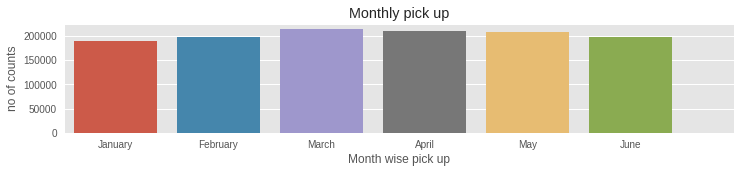

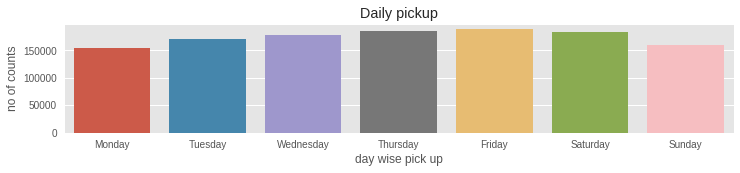

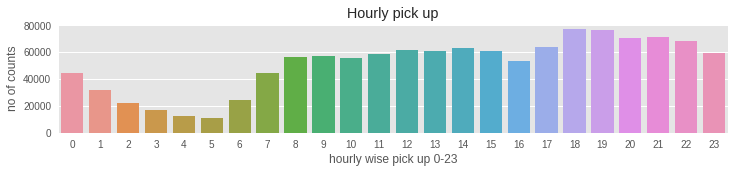

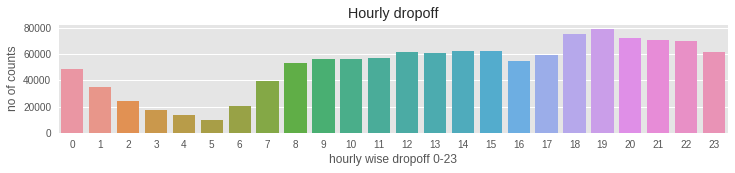

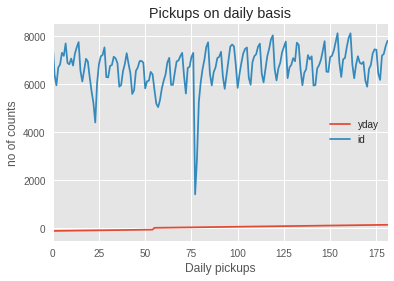

In [10]:
#Naming week of a day and month of a year
dow_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mm_names=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#Grouping month wise
train['mm_pickup']=train.pickup_datetime.dt.month.astype(np.int8)
train['mm_dropoff']=train.dropoff_datetime.dt.month.astype(np.int8)

test['mm_pickup']=test.pickup_datetime.dt.month.astype(np.int8)

#Grouping day wise
train['dow_pickup']=train.pickup_datetime.dt.weekday.astype(np.int8)
train['dow_dropoff']=train.dropoff_datetime.dt.weekday.astype(np.int8)

test['dow_pickup']=test.pickup_datetime.dt.weekday.astype(np.int8)

#Grouping day of year wise
train['yday']=train.pickup_datetime.dt.dayofyear.astype(np.int8)
test['yday']=test.pickup_datetime.dt.dayofyear.astype(np.int8)

#Grouping hour wise
train['hh_pickup']=train.pickup_datetime.dt.hour.astype(np.int8)
train['hh_dropoff']=train.dropoff_datetime.dt.hour.astype(np.int8)

test['hh_pickup']=test.pickup_datetime.dt.hour.astype(np.int8)

#Plotting pickup wise
#Monthly
plt.figure(figsize=(12,2))
month_wise=train.groupby('mm_pickup').agg({'id':'count'}).reset_index()
sns.barplot(x='mm_pickup',y='id',data=month_wise)
plt.xlabel('Month wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),mm_names[:6])
plt.title('Monthly pick up')
pass

#Day of a week
plt.figure(figsize=(12,2))
day_wise=train.groupby('dow_pickup').agg({'id':'count'}).reset_index()
sns.barplot(x='dow_pickup',y='id',data=day_wise)
plt.xlabel('day wise pick up')
plt.ylabel('no of counts')
plt.xticks(range(0,7),dow_names)
plt.title('Daily pickup')
pass

#Hourly
plt.figure(figsize=(12,2))
hour_wise=train.groupby('hh_pickup').agg({'id':'count'}).reset_index()
sns.barplot(x='hh_pickup',y='id',data=hour_wise)
plt.xlabel('hourly wise pick up 0-23')
plt.ylabel('no of counts')
plt.title('Hourly pick up')
pass


#Hourly dropoff
plt.figure(figsize=(12,2))
hhdrop_wise=train.groupby('hh_dropoff').agg({'id':'count'}).reset_index()
sns.barplot(x='hh_dropoff',y='id',data=hhdrop_wise)
plt.xlabel('hourly wise dropoff 0-23')
plt.ylabel('no of counts')
plt.title('Hourly dropoff')
pass

#Daily dropoff
plt.figure(figsize=(12,10))
yday_wise=train.groupby('yday').agg({'id':'count'}).reset_index()
yday_wise.plot(kind='line')
plt.xlabel('Daily pickups')
plt.ylabel('no of counts')
plt.title('Pickups on daily basis')
pass

In the starting 2 months, trips were slightly on a lower side(may be due to extreme cold weather). 


It also can be seen from the 1st graph that trips started decreasing after the month of March.


Maximum daily pickups usually noticed on Thursday,Friday and Saturday.


In the early morning time, as usual less traffic.
Max rush was at 6 to 7pm followed by 8 to 10pm.


From the last graph(line), there was a sudden dip in trips in the middle of March. 

We will be using weather data to check for the further insights on a sudden dip in trips.

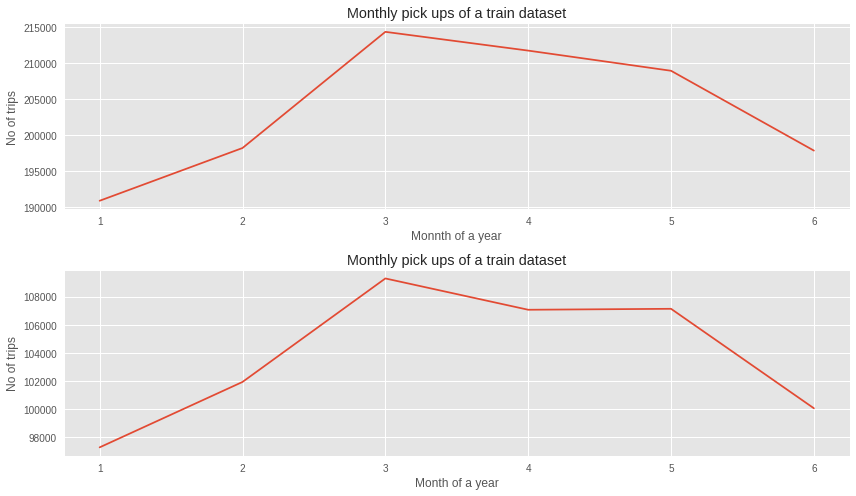

In [11]:
#Checking the pickups on a daily basis comparing train and test dataset
fig, ax= plt.subplots(nrows=2,ncols=1,figsize=(12,7))
plt.subplot(211)
trips_train=train.groupby('mm_pickup').agg({'id':'count'})
plt.plot(trips_train)
plt.title('Monthly pick ups of a train dataset')
plt.xlabel('Monnth of a year')
plt.ylabel('No of trips')
pass

plt.subplot(212)
trips_test=test.groupby('mm_pickup').agg({'id':'count'})
plt.plot(trips_test)
plt.title('Monthly pick ups of a train dataset')
plt.xlabel('Month of a year')
plt.ylabel('No of trips')
pass

fig.tight_layout()

Same type of trip distribution in train and test datset except in the 4th month where a lil bit dip is seen in the month of April

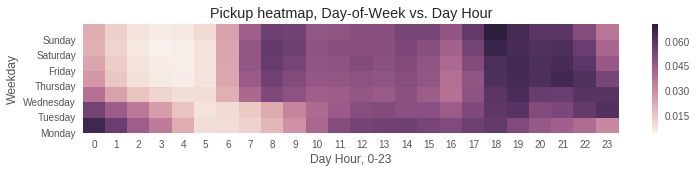

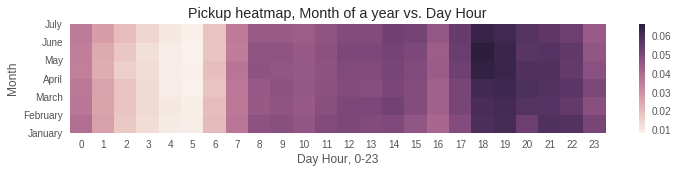

In [12]:
#heatmap hour vs day wise
plt.figure(figsize=(12,2))
plot1=pd.crosstab(train.dow_pickup,train.hh_pickup,values=train.vendor_id,aggfunc='count',normalize='index')
sns.heatmap(plot1)
plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday')
plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7),dow_names,rotation='horizontal') 
pass

#heatmap hour vs month wise
plt.figure(figsize=(12,2))
plot2=pd.crosstab(train.mm_pickup,train.hh_pickup,values=train.vendor_id,aggfunc='count',normalize='index')
sns.heatmap(plot2)
plt.title('Pickup heatmap, Month of a year vs. Day Hour')
plt.ylabel('Month')
plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7),mm_names,rotation='horizontal')
pass

From the 1st heatmap,it can be seen  that max rush noticed on ending days of a week at time around 6 pm to 10 pm.

Same pattern though traffic in the month of May and June is greater as compared to other months in the same time frame.

*Trip Duration Analysis*

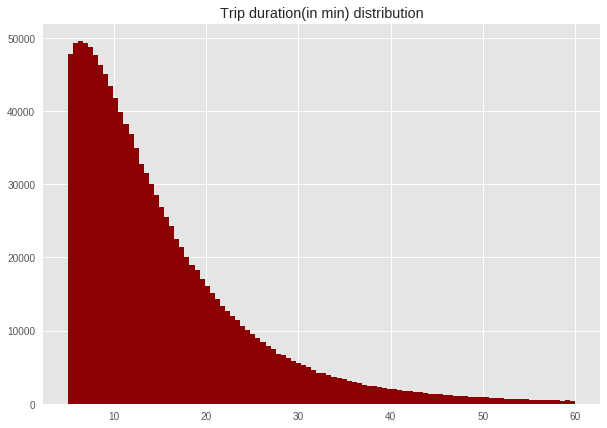

In [13]:
#Plotting Histogram 
plt.figure(figsize=(10,7))
plt.hist(train.trip_duration/60,bins=100,color='darkred')
plt.title('Trip duration(in min) distribution')
pass

Most of the trips last for less than 15-20 minutes and barely few could cross a span of 50-60 min.


People travel shorter distances.
Now how much shorter, we will further explore them using average km travelled and avg speed in km/hr.

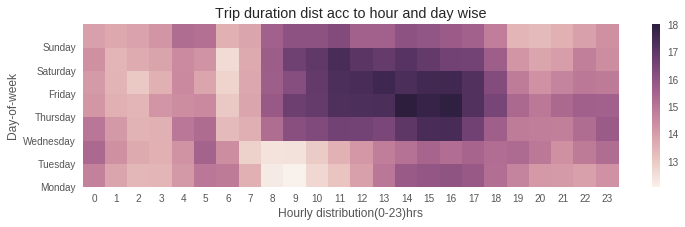

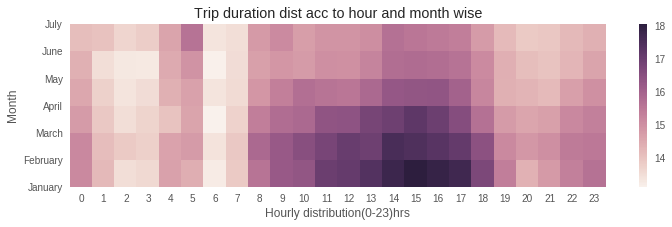

In [14]:
#Trip duration distribution acc to hour and day wise
plt.figure(figsize=(12,3))
plot1=pd.crosstab(train.dow_pickup,train.hh_pickup,values=train.trip_duration/60,aggfunc='mean')
sns.heatmap(plot1)
plt.xlabel('Hourly distribution(0-23)hrs')
plt.ylabel('Day-of-week')
plt.title('Trip duration dist acc to hour and day wise')
plt.yticks(range(0,7),dow_names,rotation='horizontal')
pass

#Trip duration distribution acc to hour and month wise
plt.figure(figsize=(12,3))
plot2=pd.crosstab(train.mm_pickup,train.hh_pickup,values=train.trip_duration/60,aggfunc='mean')
sns.heatmap(plot2)
plt.xlabel('Hourly distribution(0-23)hrs')
plt.ylabel('Month')
plt.title('Trip duration dist acc to hour and month wise')
plt.yticks(range(0,7),mm_names,rotation='horizontal')
pass


No of trips that lasted for the max duration was noticed on Thursday,Friday and Saturday betwen 8 AM to 5 PM and if we go by Month vs Hour distribution then in the starting months of 2016 larger trip duration lasted during 2 to 5 PM.


Analyzing trips with rspect to **Vendor**

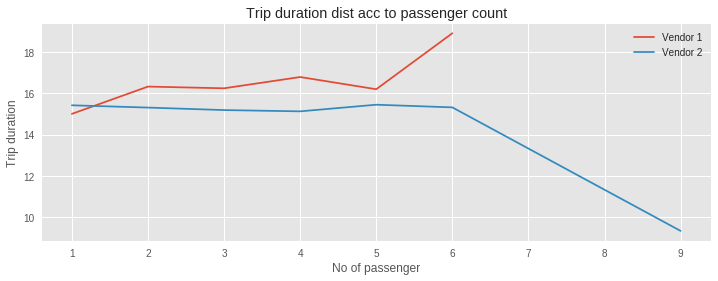

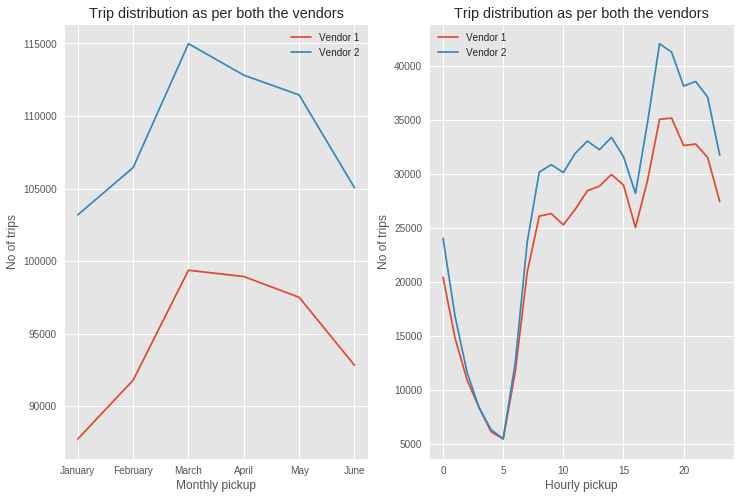

In [15]:
#Npo of trips acc to passenger count
plt.figure(figsize=(12,4))
table=pd.crosstab(index=train.passenger_count ,columns=train.vendor_id ,values=train.trip_duration/60, aggfunc='mean')
plt.plot(table)
plt.legend(['Vendor 1','Vendor 2'])
plt.xlabel('No of passenger')
plt.ylabel('Trip duration')
plt.title('Trip duration dist acc to passenger count')
pass

plt.subplots(nrows=1,ncols=2,figsize=(12,8))

#No of trips on the basis of Month wrt Vendor
plt.subplot(121)
data = pd.crosstab(index=train.mm_pickup,columns=train.vendor_id,values=train.id,aggfunc='count')
plt.title('Trip distribution as per both the vendors')
plt.xlabel('Monthly pickup')
plt.ylabel('No of trips')
plt.xticks(range(1,7),mm_names)
plt.plot(data)
plt.legend(['Vendor 1','Vendor 2'])
pass

#No of trips on the basis of Month wrt Vendor
plt.subplot(122)
data1 = pd.crosstab(index=train.hh_pickup,columns=train.vendor_id,values=train.id,aggfunc='count')
plt.title('Trip distribution as per both the vendors')
plt.xlabel('Hourly pickup')
plt.ylabel('No of trips')
plt.plot(data1)
plt.legend(['Vendor 1','Vendor 2'])
pass

Trips taken by Vendor 1 lasted for greater trip duration as compared to Vendor2. 

But, Vendor 2 took greater trips(from the 2nd left graph) as compared to the other vendor and with varying passenger count as well.


At the early hours, both the vendors took the same no of trips. But after 7 or 8 AM, Vendor 2 took larger trips as comapred to Vendor 1.

*Checking trips wrt storing or not storing the trip and then forwarding*

N    1215322
Y       6792
Name: store_and_fwd_flag, dtype: int64


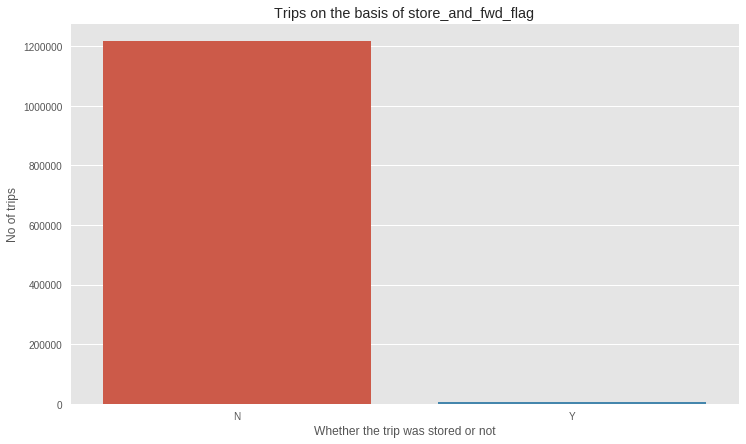

In [16]:
plt.figure(figsize=(12,7))

store=train.groupby('store_and_fwd_flag').agg({'id':'count'}).reset_index()
sns.barplot(x='store_and_fwd_flag',y='id',data=store)
plt.xlabel('Whether the trip was stored or not')
plt.ylabel('No of trips')
plt.title('Trips on the basis of store_and_fwd_flag')
pass

print(train['store_and_fwd_flag'].value_counts())


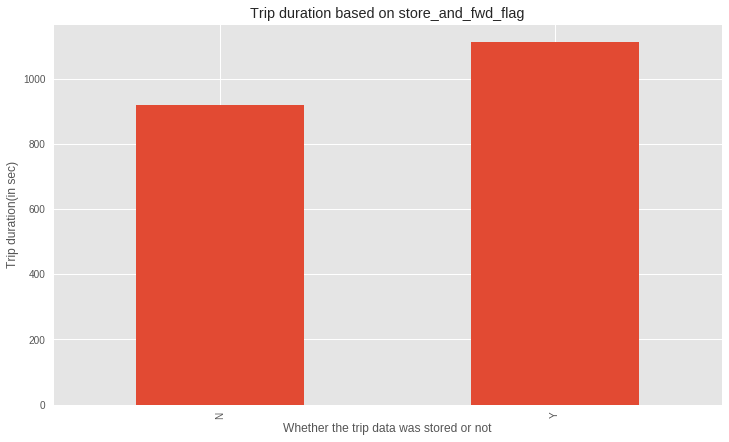

In [17]:
plt.figure(figsize=(12,7))
store=train.groupby('store_and_fwd_flag')['trip_duration'].mean()
store.plot(kind='bar',x='store_and_fwd_flag',y='trip_duration')
plt.xlabel('Whether the trip data was stored or not')
plt.ylabel('Trip duration(in sec)')
plt.title('Trip duration based on store_and_fwd_flag')
pass

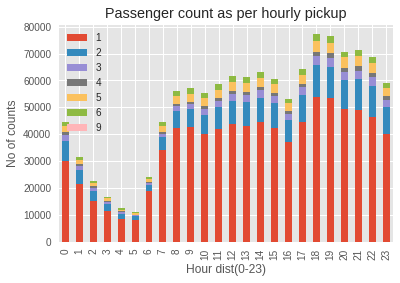

In [18]:
#Passenger count as per hourly pickup
plt.figure(figsize=(19,15))
hourly_passenger=train.groupby(['hh_pickup','passenger_count']).size().unstack()
hourly_passenger.plot(kind='bar',stacked=True,legend=False)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('No of counts')
plt.title('Passenger count as per hourly pickup')
plt.legend(loc="upper left")
pass

#Clearly visible in the graph pattern distribution on hourly basis according to passenger count.

Based on the above visulization plots, maximum no of trips were reported as "N" in storing the data and the mean trip duration was higher on those trips where trip data was stored.

Now for further deep analysis, we need to create a couple of columns:

*Column 1* - **Distance**

*Column 2* - **Speed**

We are creating a new column : Distance using **Haversine** formula which takes into consideration of latitude and longitude coordinates.

By far, Haversine formula is the most widely formula used

As the coordinates are concentrated tigthly on the poles than on the Equator.
We are taking Earth's radius to be **6371** which is greater than at the poles.

As the Earth is not a perfect sphere, there will be few descrepancies in calculating distance using this formula

In [19]:
#Haversine formula to calculate distance using longitude and latuitude coordinates
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371*1.1 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

#Iterating over each row of the 4 columns
dist=[]
for i,row in train.iterrows():
    x=distance((train.pickup_latitude[i],train.pickup_longitude[i]),(train.dropoff_latitude[i],train.dropoff_longitude[i]))
    dist.append(x)

#Naming it as a new column
train['distance_km']=dist

In [20]:
#Haversine formula to calculate distance using longitude and latuitude coordinates
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371*1.1 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

#Iterating over each row of the 4 columns
dist=[]
for i,row in test.iterrows():
    x=distance((test.pickup_latitude[i],test.pickup_longitude[i]),(test.dropoff_latitude[i],test.dropoff_longitude[i]))
    dist.append(x)

#Naming it as a new column
test['distance_km']=dist

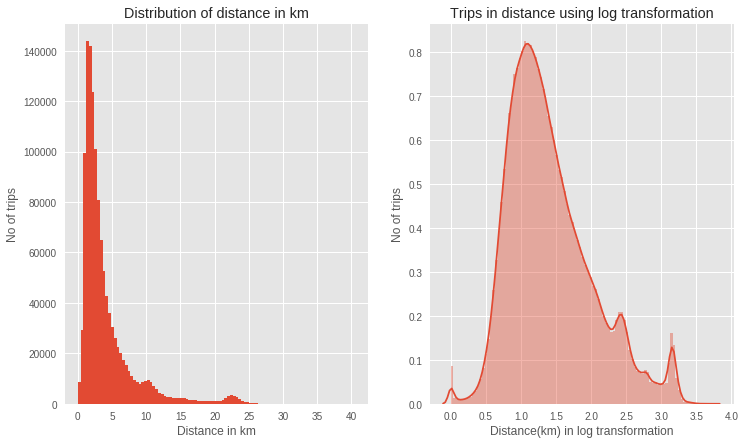

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram
plt.subplot(121)
plt.hist(train['distance_km'],bins=100)
plt.xlabel('Distance in km')
plt.ylabel('No of trips')
plt.title('Distribution of distance in km')
pass

#Plotting histogram with a log transformation
plt.subplot(122)
train['log_distance']=np.log(train['distance_km'].values + 1)
sns.distplot(train['log_distance'].values,bins=100)
plt.xlabel('Distance(km) in log transformation')
plt.ylabel('No of trips')
plt.title('Trips in distance using log transformation')

#Max trips lasted for shorter distances

Now analyzing distribution of distance travelled across days, hours and month of a year along with the passenger count.

Majority of the distance are shorter in km.

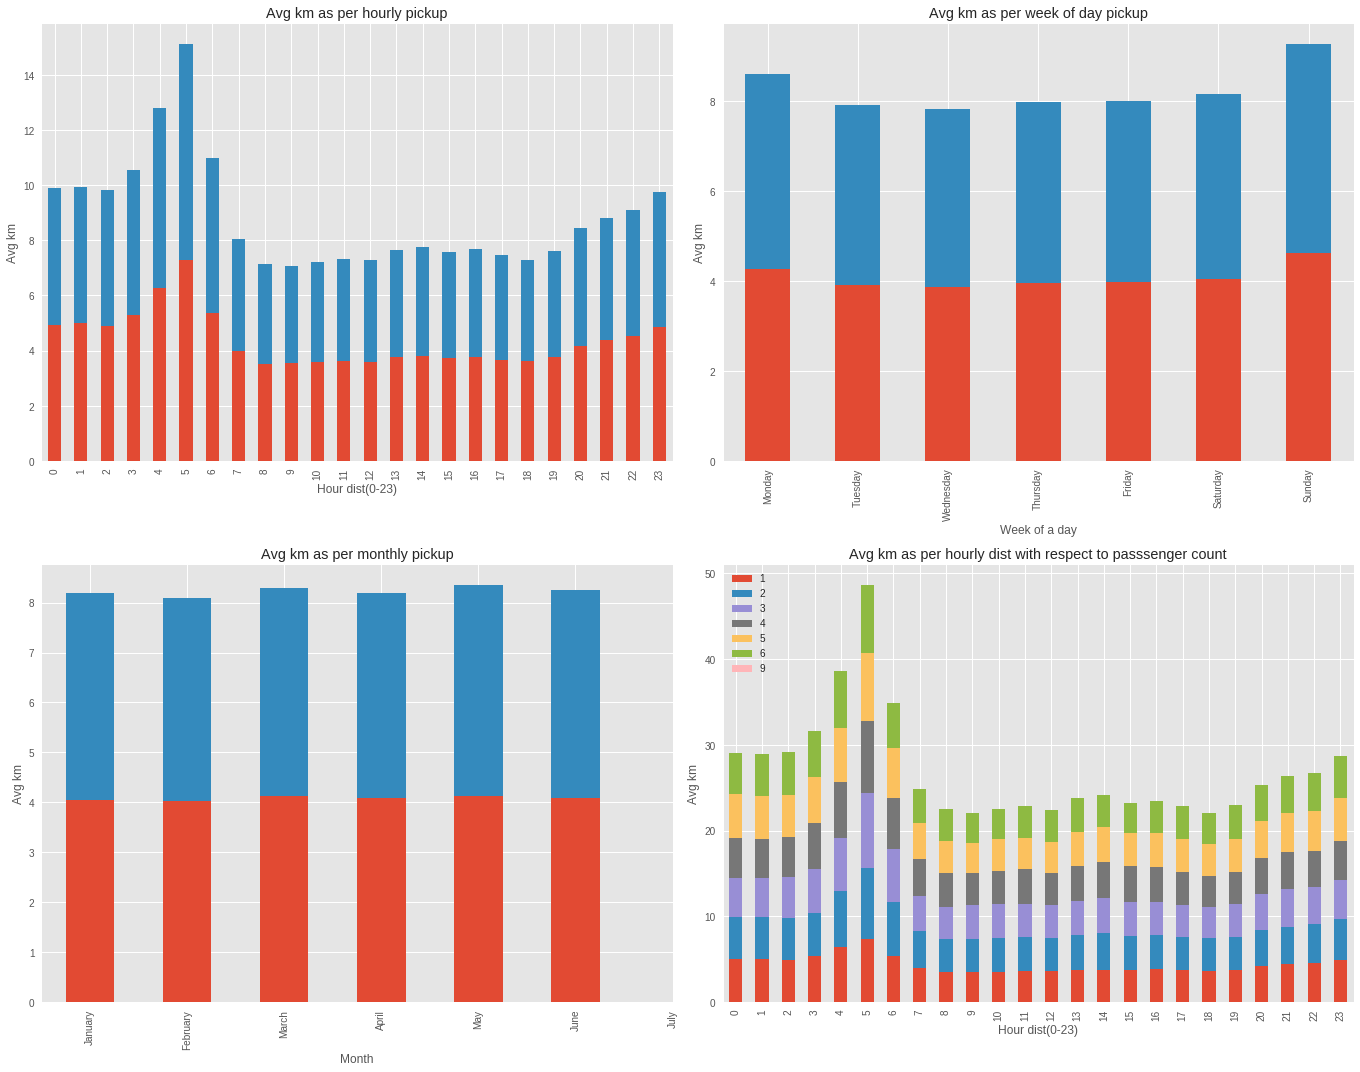

In [22]:
#Mean distance over different analysis
data1=train.groupby(['hh_pickup','vendor_id'])['distance_km'].mean().unstack()
data2=train.groupby(['dow_pickup','vendor_id'])['distance_km'].mean().unstack()
data3=train.groupby(['mm_pickup','vendor_id'])['distance_km'].mean().unstack()
data4=train.groupby(['hh_pickup','passenger_count'])['distance_km'].mean().unstack()

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(19, 15))

#Avg km as per hourly pickup
figure=plt.subplot(2,2,1)
data1.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('Avg km')
plt.title('Avg km as per hourly pickup')
pass

#Avg km as per week of day pickup
figure=plt.subplot(2,2,2)
data2.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Week of a day')
plt.ylabel('Avg km')
plt.title('Avg km as per week of day pickup')
plt.xticks(range(0,7),dow_names)
pass

#Avg km as per monthyly pickup
figure=plt.subplot(2,2,3)
data3.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Month')
plt.ylabel('Avg km')
plt.title('Avg km as per monthly pickup')
plt.xticks(range(0,7),mm_names)
pass

figure=plt.subplot(2,2,4)
data4.plot.bar(stacked=True,legend=False,ax=figure)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('Avg km')
plt.title('Avg km as per hourly dist with respect to passsenger count')
plt.legend(loc = "upper left")
pass

fig.tight_layout()

In the early morning hours, there is a rise in km travelled. People used to prefer going other places in the early hours to avoid rush. 

In the 2nd barplot, there is a rise in km travelled on Sunday, followed by Monday. People usually go or come from other places on a Sunday and Monday early hours.

*Creation of an another column* : **Speed**

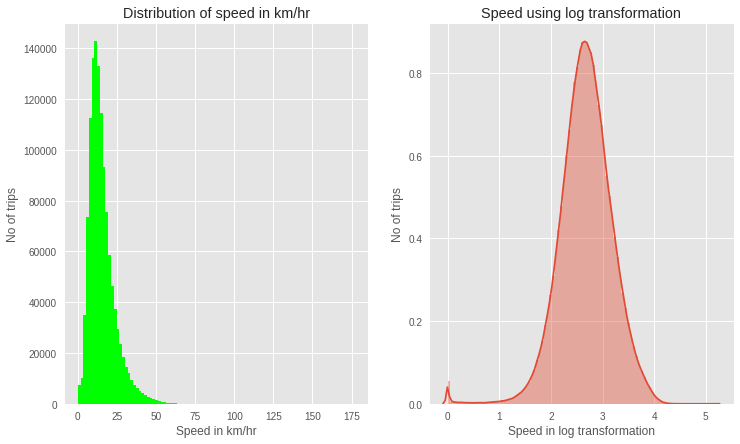

In [23]:
#Speed in km/hr
train['speed']=train.distance_km/(train.trip_duration/3600)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram
plt.subplot(121)
plt.hist(train['speed'],bins=100,color='lime')
plt.xlabel('Speed in km/hr')
plt.ylabel('No of trips')
plt.title('Distribution of speed in km/hr')
pass

plt.subplot(122)
train['log_speed']=np.log(train['speed'].values + 1)
sns.distplot(train['log_speed'].values,bins=100)
plt.xlabel('Speed in log transformation')
plt.ylabel('No of trips')
plt.title('Speed using log transformation')

As the distance travelled and trip duration are very low. So is the case with the average speed over trips.

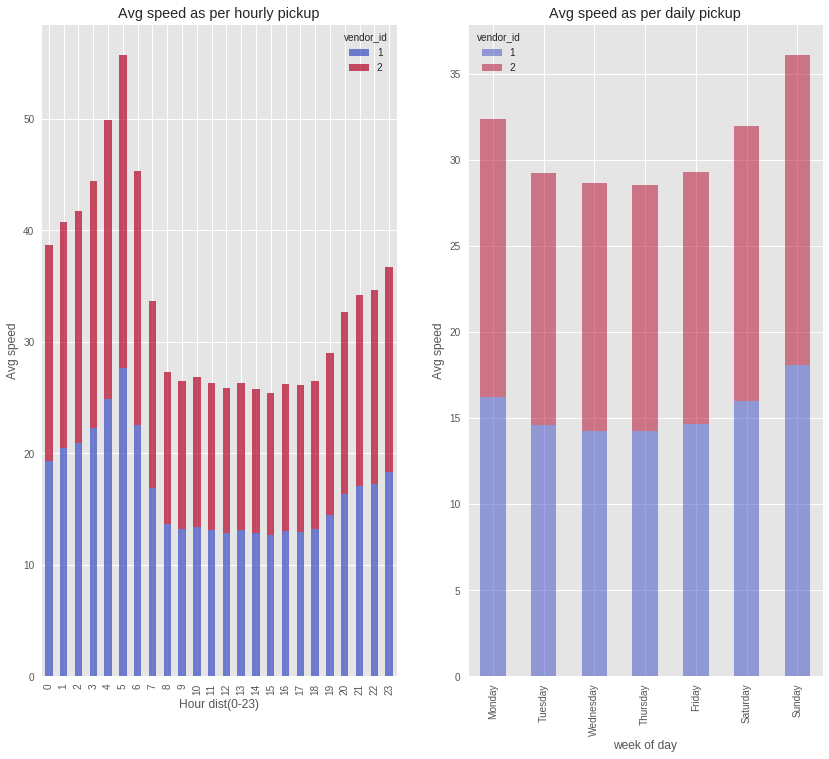

In [24]:
#Analyzing average speed over different parameters

data1=train.groupby(['hh_pickup','vendor_id'])['speed'].mean().unstack()
data2=train.groupby(['dow_pickup','vendor_id'])['speed'].mean().unstack()

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(14, 12))

figure=plt.subplot(121)
data1.plot(kind='bar',stacked=True,alpha=0.7,colormap='coolwarm',ax=figure)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('Avg speed')
plt.title('Avg speed as per hourly pickup')
pass

#Avg speed as per week of day
figure=plt.subplot(122)
data2.plot(kind='bar',stacked=True,alpha=0.5,colormap='coolwarm',ax=figure)
plt.xlabel('week of day')
plt.ylabel('Avg speed')
plt.title('Avg speed as per daily pickup')
plt.xticks(range(0,7),dow_names)
pass

From the above graphs, it is not that people prefer travelling more on Sunday and Monday. Due to fewer no of pickups in early morning hours, average speed also rises.

How our **train and test datset top 5 entries** look like after creating few new columns

In [25]:
#Dropping log_speed column
train=train.drop('log_speed',axis=1)

In [26]:
print(train.head())

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag    ...      mm_pickup  mm_dropoff  \
0         40.765602                  N    ...              3    

Analyzing **NYC Map**(pickups and dropoffs)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  del sys.path[0]


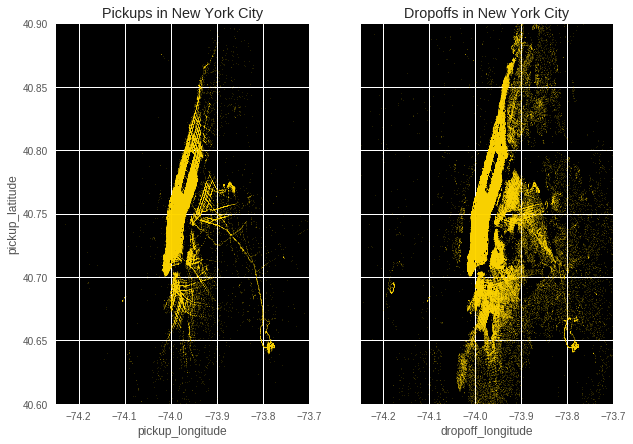

In [27]:
#Plotting the pickup and dropoff locations of New York
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,7))

#Plotting pickup map in  NYC
Pickups=train.plot(kind='scatter',x='pickup_longitude',y='pickup_latitude',s=.02,alpha=.6,xlim=(long_min,long_max),ylim=(lat_min,lat_max),color='gold',subplots=True,ax=ax1)
ax1.set_title('Pickups in New York City')
ax1.set_axis_bgcolor('black') # black as a background color
pass

#Plotting pickup map in  NYC
Dropoffs=train.plot(kind='scatter',x='dropoff_longitude',y='dropoff_latitude',s=.02,alpha=.6,xlim=(long_min,long_max),ylim=(lat_min,lat_max),color='gold',subplots=True,ax=ax2)
ax2.set_title('Dropoffs in New York City')
ax2.set_axis_bgcolor('black') # black as a background color
pass

fig.tight_layout()

Pickups are almost concentrated in Manhatten and dropoffs across the NYC.
This approximatley could explain the reason why Vendor 2 pickups were greater than Vendor 1. May be Vendor 2 was operating mostly in the Manhatten region.

Analyzing NYC Map in 4 shifts:
Shift 1 - 7AM to 11 AM
Shift 2 - 11AM to 5PM
Shift 3 - 5PM to 11PM
Shift 4 - 11PM to 7AM

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


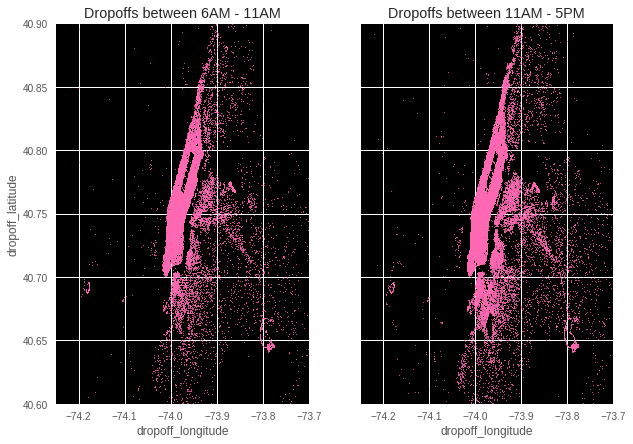

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,7))

#Shift 1
Mtime=train[(train['hh_dropoff']>=7) & (train['hh_dropoff']<11)]
Mtime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.2,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax1)
ax1.set_title('Dropoffs between 6AM - 11AM')
ax1.set_axis_bgcolor('black')
pass

#Shift 2 
Atime=train[(train['hh_dropoff']>=11) & (train['hh_dropoff']<17)]
Atime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.2,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax2)
ax2.set_title('Dropoffs between 11AM - 5PM')
ax2.set_axis_bgcolor('black')
pass

fig.tight_layout()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


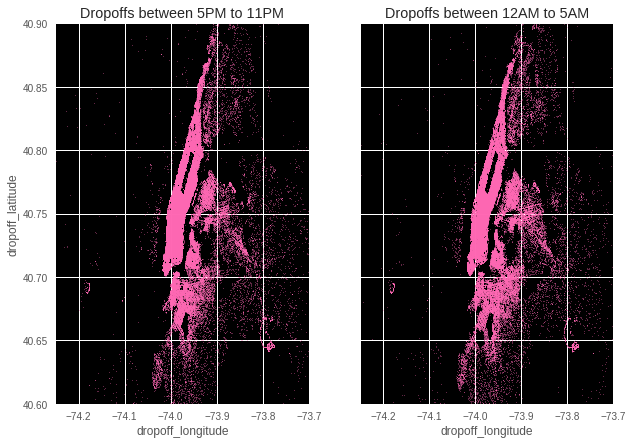

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,7))

#Shift 3
Etime=train[(train['hh_dropoff']>=17) & (train['hh_dropoff']<23)]
Etime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.05,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax1)
ax1.set_title('Dropoffs between 5PM to 11PM')
ax1.set_axis_bgcolor('black')
pass

#Shift 4 : Night Time - 0AM to 5AM
Ntime=train[(train['hh_dropoff']>=0) & (train['hh_dropoff']<7)]
Ntime.plot(kind='scatter',xlim=(long_min,long_max),ylim=(lat_min,lat_max),s=0.05,x='dropoff_longitude',y='dropoff_latitude',color='hotpink',subplots=True,ax=ax2)
ax2.set_title('Dropoffs between 12AM to 5AM')
ax2.set_axis_bgcolor('black')
pass

Impact of  **Weather** on  Trips 

In [30]:
weather=pd.read_csv('../input/weather-data-in-new-york-city-2016/weather_data_nyc_centralpark_2016.csv')
weather['date']=pd.to_datetime(weather.date)
#Grouping day of a year wise
weather['yday']=weather.date.dt.dayofyear
print(weather.head())


        date  maximum temerature  minimum temperature  average temperature  \
0 2016-01-01                  42                   34                 38.0   
1 2016-02-01                  40                   32                 36.0   
2 2016-03-01                  45                   35                 40.0   
3 2016-04-01                  36                   14                 25.0   
4 2016-05-01                  29                   11                 20.0   

  precipitation snow fall snow depth  yday  
0          0.00       0.0          0     1  
1          0.00       0.0          0    32  
2          0.00       0.0          0    61  
3          0.00       0.0          0    92  
4          0.00       0.0          0   122  


Replacing **Traces** with their standarad measure of very small floating number

In [31]:
fall=[.1 if c=="T" else float(c) for c in weather['snow fall']]
rain=[.01 if c=="T" else float(c) for c in weather['precipitation']]
depth=[1 if c=="T" else int(c) for c in weather['snow depth']]
weather['snow fall']=fall
weather['precipitation']=rain
weather['snow depth']=depth
print(weather.describe())

       maximum temerature  minimum temperature  average temperature  \
count          366.000000           366.000000           366.000000   
mean            64.625683            49.806011            57.215847   
std             18.041787            16.570747            17.124760   
min             15.000000            -1.000000             7.000000   
25%             50.000000            37.250000            44.000000   
50%             64.500000            48.000000            55.750000   
75%             81.000000            65.000000            73.500000   
max             96.000000            81.000000            88.500000   

       precipitation   snow fall  snow depth        yday  
count     366.000000  366.000000  366.000000  366.000000  
mean        0.115874    0.102459    0.295082  183.500000  
std         0.309447    1.441487    1.930385  105.799338  
min         0.000000    0.000000    0.000000    1.000000  
25%         0.000000    0.000000    0.000000   92.250000  
50%   

In [32]:
#Merging both the train and weather dataset using the date as a joining column
jointrain=pd.merge(train,weather,on='yday')
print(jointrain.head())

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2129090          1 2016-03-14 14:05:39 2016-03-14 14:28:05   
2  id0256505          1 2016-03-14 15:04:38 2016-03-14 15:16:13   
3  id3863815          2 2016-03-14 04:24:36 2016-03-14 04:37:11   
4  id3817493          2 2016-03-14 14:57:56 2016-03-14 15:15:26   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.975090        40.758766         -73.953201   
2                1        -73.994484        40.745087         -73.998993   
3                3        -73.944359        40.714489         -73.910530   
4                1        -73.952881        40.766468         -73.978630   

   dropoff_latitude store_and_fwd_flag     ...      distance_km  log_distance  \
0         40.765602                  N     ...         1.64

Analyzing **average speed and daily trips with respect to snow fall** and will see whether snow fall(in inches) had an impact on both the speed and trips.

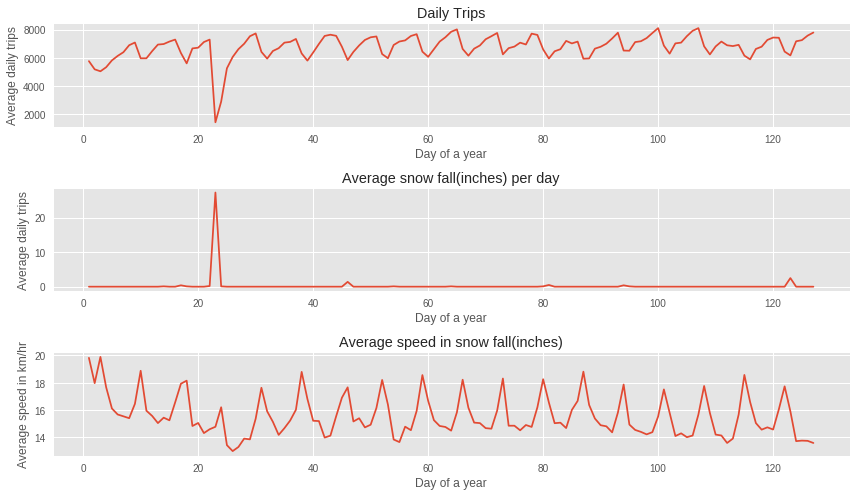

In [33]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12, 7))

#Plotting no of trips per day
figure=plt.subplot(311)
table=jointrain.groupby('yday').agg({'id':'count'})
plt.plot(table)
plt.xlabel('Day of a year')
plt.ylabel('Average daily trips')
plt.title('Daily Trips')
pass

#Plotting average snow depth per day
figure=plt.subplot(312)
data=jointrain.groupby('yday').agg({'snow fall':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('Average daily trips')
plt.title('Average snow fall(inches) per day')
plt.plot(data)
pass

#Plotting average speed in snow depth
figure=plt.subplot(313)
data=jointrain.groupby('yday').agg({'speed':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('Average speed in km/hr')
plt.title('Average speed in snow fall(inches)')
plt.plot(data)
pass

fig.tight_layout()

Impact of **max and min temperature** on daily trips. Though I think that temperature won't cast a impact still we check it

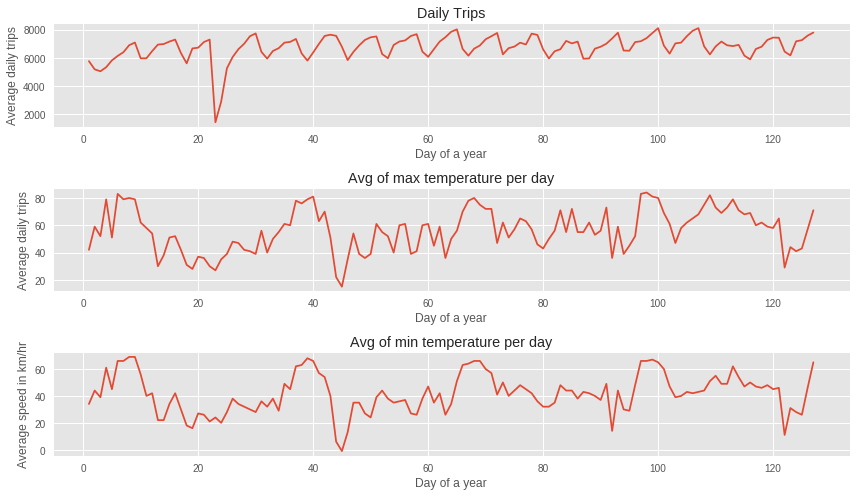

In [34]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12, 7))

#Plotting no of trips per day
figure=plt.subplot(311)
table=jointrain.groupby('yday').agg({'id':'count'})
plt.plot(table)
plt.xlabel('Day of a year')
plt.ylabel('Average daily trips')
plt.title('Daily Trips')
pass

#Plotting average snow depth per day
figure=plt.subplot(312)
data=jointrain.groupby('yday').agg({'maximum temerature':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('Average daily trips')
plt.title('Avg of max temperature per day')
plt.plot(data)
pass

#Plotting average speed in snow depth
figure=plt.subplot(313)
data=jointrain.groupby('yday').agg({'minimum temperature':'mean'})
plt.xlabel('Day of a year')
plt.ylabel('Average speed in km/hr')
plt.title('Avg of min temperature per day')
plt.plot(data)
pass

fig.tight_layout()

As previously though that excessive snow fall will definitely cast a impact as American vehicles had a ground clearance of apprx 8 inches.
Temperature definitely won't have an impact

**Modification** 

Creating **Seasons** -

S1 = Month of January and February as they are the cold months
S2=Month of March, April and May less cold 
S3=Month of June as a little warmer month

In [35]:
#Joining test dataset with weather using day of year
test['yday']=test.pickup_datetime.dt.dayofyear.astype(np.int8)

#Merging both the train and weather dataset using the date as a joining column
jointest=pd.merge(test,weather,on='yday')

In [36]:
#For the train dataset
jointrain['s1']=jointrain['mm_pickup']<=2
jointrain['s2']=jointrain['mm_pickup'].between(3,5)
jointrain['s3']=jointrain['mm_pickup']>=6

#For the test dataset
jointest['s1']=jointest['mm_pickup']<=2
jointest['s2']=jointest['mm_pickup'].between(3,5)
jointest['s3']=jointest['mm_pickup']>=6

**Model and Predict**

Importing **scikit-learn** packages

In [37]:
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
print(jointrain.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'mm_pickup', 'mm_dropoff', 'dow_pickup', 'dow_dropoff',
       'yday', 'hh_pickup', 'hh_dropoff', 'distance_km', 'log_distance',
       'speed', 'date', 'maximum temerature', 'minimum temperature',
       'average temperature', 'precipitation', 'snow fall', 'snow depth', 's1',
       's2', 's3'],
      dtype='object')


In [39]:
print(jointest.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'mm_pickup', 'dow_pickup',
       'yday', 'hh_pickup', 'distance_km', 'date', 'maximum temerature',
       'minimum temperature', 'average temperature', 'precipitation',
       'snow fall', 'snow depth', 's1', 's2', 's3'],
      dtype='object')


Checking significant variables through **ANOVA** table

In [40]:
x=jointrain[['distance_km','pickup_longitude','passenger_count','vendor_id','pickup_latitude','yday','dropoff_longitude','dropoff_latitude','dow_pickup','hh_pickup','mm_pickup','snow depth','snow fall']]
Y=jointrain['trip_duration']
x=sm.add_constant(x)
model=sm.OLS(Y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                 8.697e+04
Date:                Fri, 22 Sep 2017   Prob (F-statistic):               0.00
Time:                        06:01:43   Log-Likelihood:            -6.2710e+06
No. Observations:              857672   AIC:                         1.254e+07
Df Residuals:                  857658   BIC:                         1.254e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.01e+05   1599.652    -63.108      0.000   -1.04e+05   -9.78e+04
distance_km         105.0755      0.124    847.867      0.000     104.833     105.318
pickup_longitude   -616.1487     12.294    -50.117      0.000    -640.245    -592.052
passenger_count       2.3288      0.310      7.519      0.000       1.722       2.936
vendor_id            -0.5399      0.819     -0.659      0.510      -2.146       1.066
pickup_latitude    1214.2750     16.069     75.567      0.000    1182.781    1245.769
yday                  0.7796      0.046     17.001      0.000       0.690       0.870
dropoff_longitude  -714.0481     12.486    -57.188      0.000    -738.520    -689.576
dropoff_latitude  -1141.7374     13.565    -84.170      0.000   -1168.324   -1115.151
dow_pickup          -11.4126      0.204    -55.926      0.000     -11.813     -11.013
hh_pickup             3.1094      0.062     49.893      0.000       2.987       3.232
mm_pickup             0.7495      1.402      0.535      0.593      -1.998       3.497
snow depth            8.1844      0.157     51.992      0.000       7.876       8.493
snow fall            -0.0640      0.349     -0.183      0.855      -0.748       0.620
==============================================================================
Omnibus:                   230591.997   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           887031.358
Skew:                           1.304   Prob(JB):                         0.00
Kurtosis:                       7.245   Cond. No.                     5.65e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We won't be including those variables whose p-values are greater than 0.5 as they are not statistically significant or in other terms they aren't capable of making an impact on dependent variable.

In [41]:
features=['distance_km','pickup_longitude','pickup_latitude','yday','dropoff_longitude','dropoff_latitude','dow_pickup','hh_pickup','snow depth'] 
X_train=jointrain[features]
y_train=jointrain['trip_duration']
feature_cols=['distance_km','pickup_longitude','pickup_latitude','yday','dropoff_longitude','dropoff_latitude','dow_pickup','hh_pickup','snow depth'] 
X_test=jointest[feature_cols]

In [42]:
X_Train,X_test,Y_train,Y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [43]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train,y_train)
pred=lm.predict(X_test)
accuracy=round(lm.score(X_train,y_train)*100,2)
accuracy

56.859999999999999

In [44]:
sub.head()

NameError: name 'sub' is not defined